In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on FashionMNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on FashionMNIST dataset

In [0]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

mean, std = 0.28604059698879553, 0.35302424451492237

train_dataset = FashionMNIST('../data/FashionMNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('../data/FashionMNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

## Common setup

In [0]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    plt.legend(fashion_mnist_classes)

def extract_embeddings(dataloader, model):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 2))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [0]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [6]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/60000 (0%)]	Loss: 2.414188	Accuracy: 10.15625
Train: [12800/60000 (21%)]	Loss: 2.688702	Accuracy: 27.489276960784313
Train: [25600/60000 (43%)]	Loss: 1.165615	Accuracy: 42.45436262376238
Train: [38400/60000 (64%)]	Loss: 0.836480	Accuracy: 51.759105960264904
Train: [51200/60000 (85%)]	Loss: 0.735616	Accuracy: 56.91853233830846
Epoch: 1/20. Train set: Average loss: 1.2599	Accuracy: 59.461666666666666
Epoch: 1/20. Validation set: Average loss: 0.6360	Accuracy: 75.16
Train: [0/60000 (0%)]	Loss: 0.483415	Accuracy: 81.640625
Train: [12800/60000 (21%)]	Loss: 0.598352	Accuracy: 77.82628676470588
Train: [25600/60000 (43%)]	Loss: 0.602865	Accuracy: 78.31064356435644
Train: [38400/60000 (64%)]	Loss: 0.535301	Accuracy: 79.38741721854305
Train: [51200/60000 (85%)]	Loss: 0.528574	Accuracy: 80.10921952736318
Epoch: 2/20. Train set: Average loss: 0.5591	Accuracy: 80.52166666666666
Epoch: 2/20. Validation set: Average loss: 0.5756	Accuracy: 80.56
Train: [0/60000 (0%)]	Loss: 0.572737	Accuracy:

Text(0.5,1,'Test set')

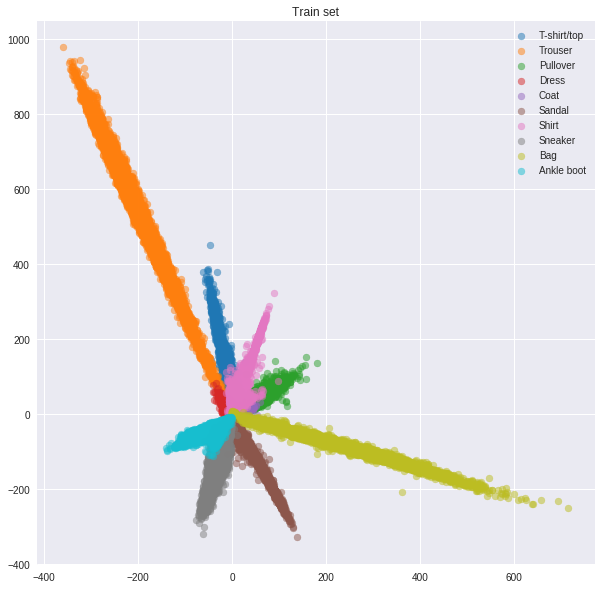

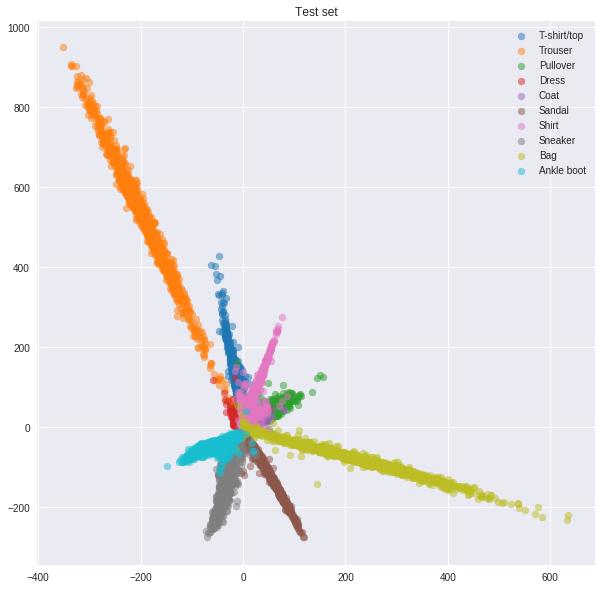

In [7]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
plt.title('Train set')
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)
plt.title('Test set')

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [0]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [9]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.229144
Train: [12800/60000 (21%)]	Loss: 0.062349
Train: [25600/60000 (43%)]	Loss: 0.047946
Train: [38400/60000 (64%)]	Loss: 0.047465
Train: [51200/60000 (85%)]	Loss: 0.043733
Epoch: 1/20. Train set: Average loss: 0.0495
Epoch: 1/20. Validation set: Average loss: 0.0391
Train: [0/60000 (0%)]	Loss: 0.028189
Train: [12800/60000 (21%)]	Loss: 0.041735
Train: [25600/60000 (43%)]	Loss: 0.037693
Train: [38400/60000 (64%)]	Loss: 0.037996
Train: [51200/60000 (85%)]	Loss: 0.037848
Epoch: 2/20. Train set: Average loss: 0.0382
Epoch: 2/20. Validation set: Average loss: 0.0368
Train: [0/60000 (0%)]	Loss: 0.033354
Train: [12800/60000 (21%)]	Loss: 0.035493
Train: [25600/60000 (43%)]	Loss: 0.033108
Train: [38400/60000 (64%)]	Loss: 0.032692
Train: [51200/60000 (85%)]	Loss: 0.032172
Epoch: 3/20. Train set: Average loss: 0.0328
Epoch: 3/20. Validation set: Average loss: 0.0329
Train: [0/60000 (0%)]	Loss: 0.030573
Train: [12800/60000 (21%)]	Loss: 0.030816
Train: [25600/60000 (

Text(0.5,1,'Test set')

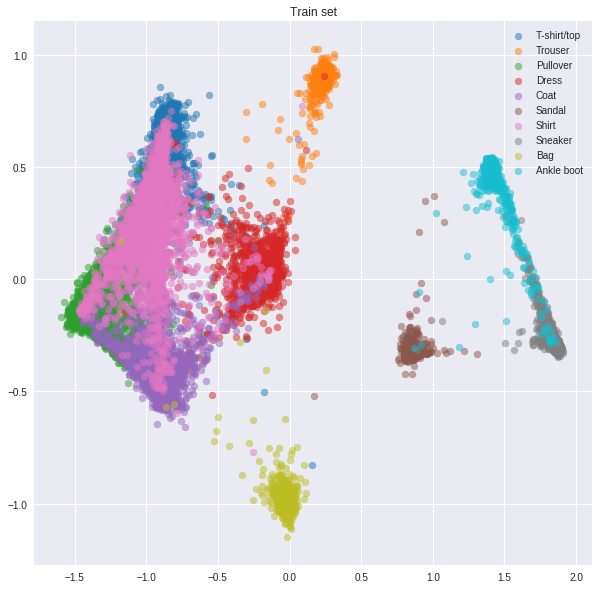

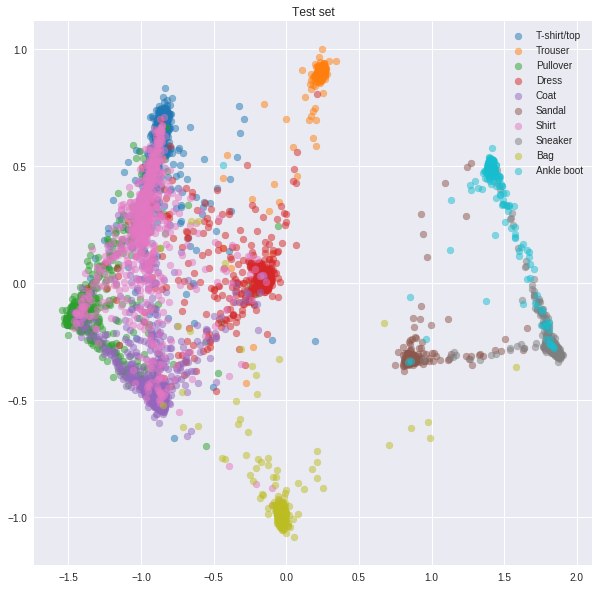

In [10]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
plt.title('Train set')
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)
plt.title('Test set')

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$

In [0]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [12]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999724
Train: [12800/60000 (21%)]	Loss: 0.282797
Train: [25600/60000 (43%)]	Loss: 0.199196
Train: [38400/60000 (64%)]	Loss: 0.188891
Train: [51200/60000 (85%)]	Loss: 0.164766
Epoch: 1/20. Train set: Average loss: 0.2029
Epoch: 1/20. Validation set: Average loss: 0.1563
Train: [0/60000 (0%)]	Loss: 0.140853
Train: [12800/60000 (21%)]	Loss: 0.149236
Train: [25600/60000 (43%)]	Loss: 0.149673
Train: [38400/60000 (64%)]	Loss: 0.137710
Train: [51200/60000 (85%)]	Loss: 0.127995
Epoch: 2/20. Train set: Average loss: 0.1395
Epoch: 2/20. Validation set: Average loss: 0.1506
Train: [0/60000 (0%)]	Loss: 0.170592
Train: [12800/60000 (21%)]	Loss: 0.134394
Train: [25600/60000 (43%)]	Loss: 0.121665
Train: [38400/60000 (64%)]	Loss: 0.126097
Train: [51200/60000 (85%)]	Loss: 0.120424
Epoch: 3/20. Train set: Average loss: 0.1239
Epoch: 3/20. Validation set: Average loss: 0.1283
Train: [0/60000 (0%)]	Loss: 0.156159
Train: [12800/60000 (21%)]	Loss: 0.114665
Train: [25600/60000 (

Text(0.5,1,'Test set')

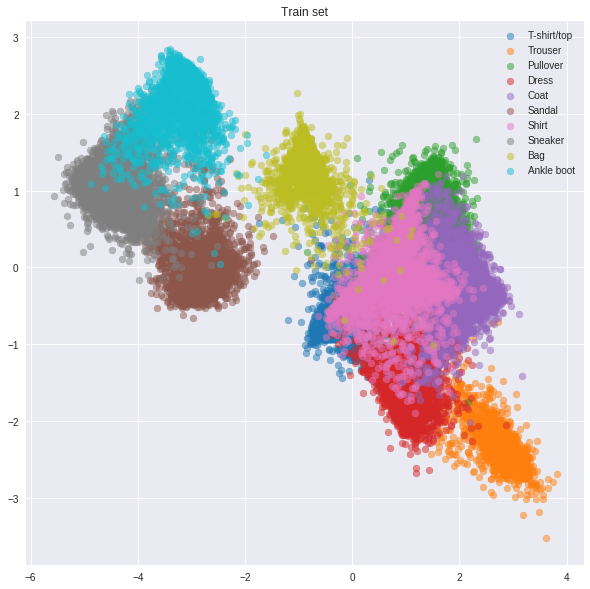

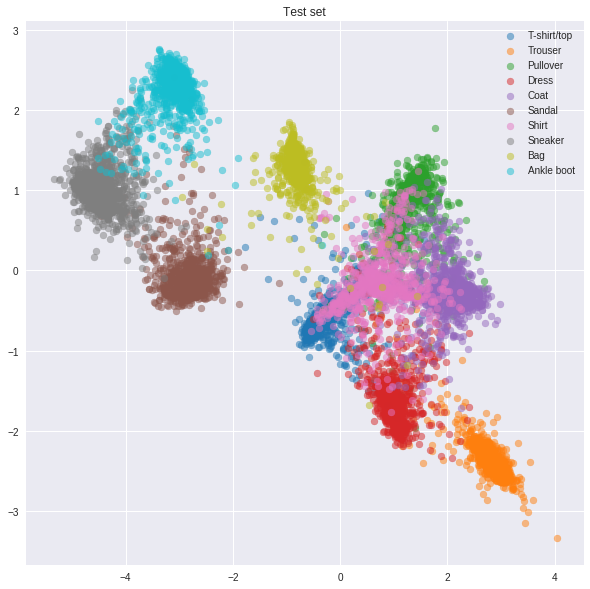

In [13]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
plt.title('Train set')
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)
plt.title('Test set')

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection

In [0]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, AllPositivePairSelector(balance=False))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [15]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.851216
Train: [12500/60000 (21%)]	Loss: 0.109923
Train: [25000/60000 (42%)]	Loss: 0.064540
Train: [37500/60000 (62%)]	Loss: 0.054828
Train: [50000/60000 (83%)]	Loss: 0.049443
Epoch: 1/20. Train set: Average loss: 0.0692
Epoch: 1/20. Validation set: Average loss: 0.0453
Train: [0/60000 (0%)]	Loss: 0.044695
Train: [12500/60000 (21%)]	Loss: 0.043947
Train: [25000/60000 (42%)]	Loss: 0.042330
Train: [37500/60000 (62%)]	Loss: 0.038850
Train: [50000/60000 (83%)]	Loss: 0.037173
Epoch: 2/20. Train set: Average loss: 0.0400
Epoch: 2/20. Validation set: Average loss: 0.0399
Train: [0/60000 (0%)]	Loss: 0.036296
Train: [12500/60000 (21%)]	Loss: 0.035726
Train: [25000/60000 (42%)]	Loss: 0.033342
Train: [37500/60000 (62%)]	Loss: 0.033459
Train: [50000/60000 (83%)]	Loss: 0.033805
Epoch: 3/20. Train set: Average loss: 0.0337
Epoch: 3/20. Validation set: Average loss: 0.0350
Train: [0/60000 (0%)]	Loss: 0.036567
Train: [12500/60000 (21%)]	Loss: 0.030198
Train: [25000/60000 (

Text(0.5,1,'Test set')

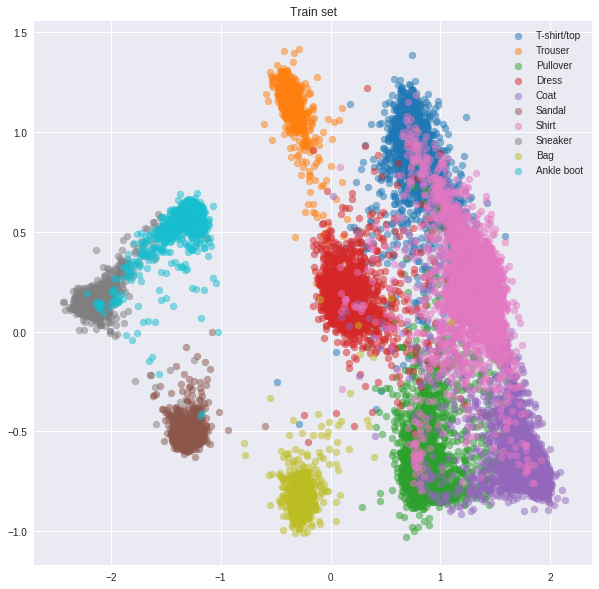

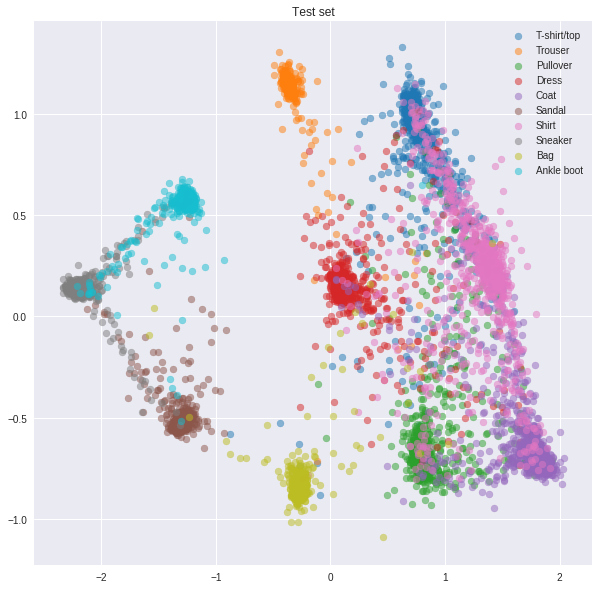

In [16]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
plt.title('Train set')
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)
plt.title('Test set')

## Online triplet selection

In [0]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [18]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999743	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.992234	Average nonzero triplets: 2811.235294117647
Train: [25000/60000 (42%)]	Loss: 0.994900	Average nonzero triplets: 2626.2871287128714
Train: [37500/60000 (62%)]	Loss: 1.000082	Average nonzero triplets: 2495.3046357615895
Train: [50000/60000 (83%)]	Loss: 0.992681	Average nonzero triplets: 2411.2537313432836
Epoch: 1/20. Train set: Average loss: 0.9979	Average nonzero triplets: 2358.5774058577404
Epoch: 1/20. Validation set: Average loss: 1.0928	Average nonzero triplets: 2129.923076923077
Train: [0/60000 (0%)]	Loss: 1.088034	Average nonzero triplets: 2195.0
Train: [12500/60000 (21%)]	Loss: 0.988725	Average nonzero triplets: 2114.1960784313724
Train: [25000/60000 (42%)]	Loss: 0.994892	Average nonzero triplets: 2073.6534653465346
Train: [37500/60000 (62%)]	Loss: 0.980427	Average nonzero triplets: 2041.523178807947
Train: [50000/60000 (83%)]	Loss: 1.013197	Average nonzero triplets: 1

Train: [50000/60000 (83%)]	Loss: 0.846464	Average nonzero triplets: 839.6716417910447
Epoch: 15/20. Train set: Average loss: 0.8614	Average nonzero triplets: 830.9958158995815
Epoch: 15/20. Validation set: Average loss: 1.2902	Average nonzero triplets: 1804.5384615384614
Train: [0/60000 (0%)]	Loss: 0.762204	Average nonzero triplets: 748.0
Train: [12500/60000 (21%)]	Loss: 0.891970	Average nonzero triplets: 847.6862745098039
Train: [25000/60000 (42%)]	Loss: 0.856722	Average nonzero triplets: 810.7623762376238
Train: [37500/60000 (62%)]	Loss: 0.827562	Average nonzero triplets: 790.1390728476821
Train: [50000/60000 (83%)]	Loss: 0.834395	Average nonzero triplets: 781.4328358208955
Epoch: 16/20. Train set: Average loss: 0.8514	Average nonzero triplets: 777.18410041841
Epoch: 16/20. Validation set: Average loss: 1.3368	Average nonzero triplets: 1673.871794871795
Train: [0/60000 (0%)]	Loss: 1.298479	Average nonzero triplets: 1274.0
Train: [12500/60000 (21%)]	Loss: 0.843409	Average nonzero trip

Text(0.5,1,'Test set')

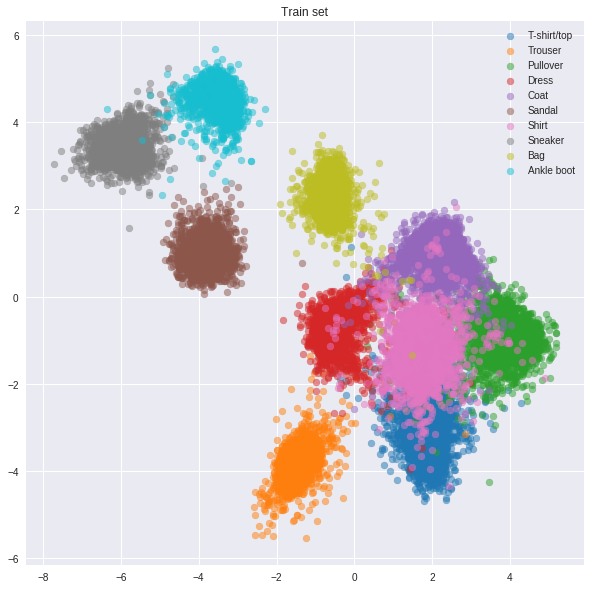

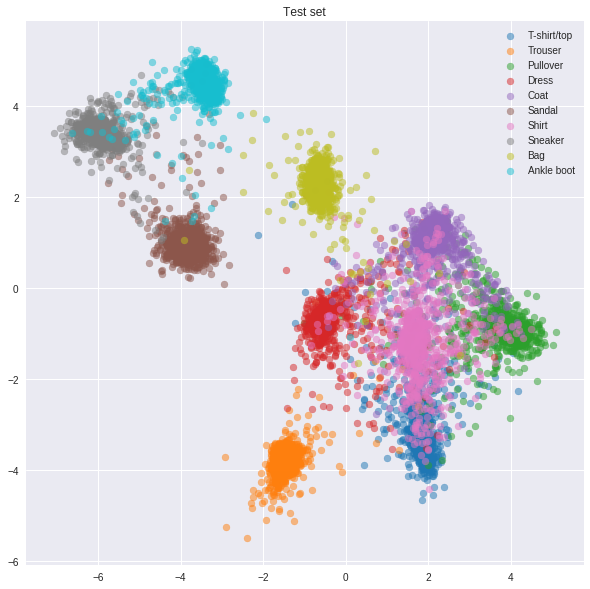

In [19]:
train_embeddings, train_labels = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings, train_labels)
plt.title('Train set')
val_embeddings, val_labels = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings, val_labels)
plt.title('Test set')